<a href="https://colab.research.google.com/github/anzapata/mcda-fintech/blob/main/02_deteccion_de_fraude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deteccion de Fraude

El objetivo de este proyecto es comparar varios modelos de clasificacion en la deteccion de fraude en transacciones.

# Definicion del Problema

Utilizaremos los datos de Kaggle: https://www.kaggle.com/mlg-ulb/creditcardfraud

Para nuestro proyecto definiremos con valor 1 ($y=1$) cuando la transaccion fue fraudulenta, y 0 ($y=0$) en otro caso.  

LOs datos contienen transacciones de tarjetas de credito de Septiembre 2013, todas de peronas que viven en Europa. En total tenemos acceso a 2 dias de transacciones, donde hubo un total de 284k transacciones con 492 fraudes. Los fraudes solo representan el **.172%** del total de transacciones.  

El task es predecir el fraude. La variable `Class` es nuestro target ($y$). Las variables ya han sido preprocesadas con PCA para mantener anonimato, por lo que es algo dificil de interpretarlas directamnte.

# Librerias

In [ ]:
# Load libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD

#Libraries for Saving the Model
from pickle import dump
from pickle import load

from pprint import pprint


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# ETL

Carguemos la funcion de pandas
[pd.read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)

In [ ]:
df= read_csv('https://github.com/uumami/workshop_riskmathics/blob/main/creditcard.csv.zip?raw=true',
              compression='zip')


In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


 Veamos su dimension

In [ ]:
df.shape

(284807, 31)

Veamos su informacion general

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

En este caso no tuvimos muchos problemas, pues la informacion ha sido pre-procesada previamente con PCA que es una tecnica de reduccion de dimensionalidad.

# Exploratory Data Analysis

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


**Balanceo de Y**

In [ ]:
class_names = {0:'Not Fraud', 1:'Fraud'}
print(df.Class.value_counts().rename(index = class_names))

Not Fraud    284315
Fraud           492
Name: Class, dtype: int64


Podemos observar como nuestras clases estan extremadamente desbalanceadas, la mayoria no son fraude.

## Descripciones Visuales y Graficas

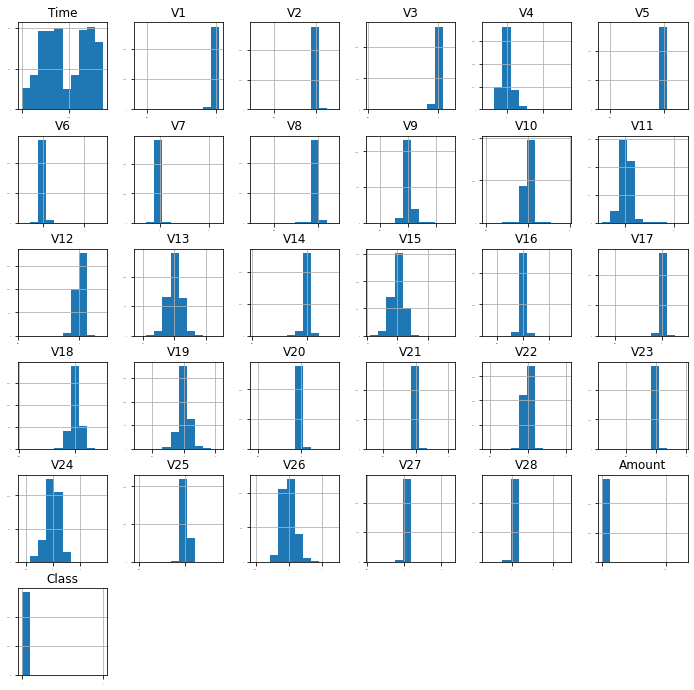

In [ ]:
# histograms
df.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

Podemos observar que la distribucion de los datos esta sesgada. Pero, dado que no conocemos el significado de cada variable, es dificil tener una interpretacion.

In [ ]:
df[['Time', 'Amount']].describe()

,Time,Amount
count,284807.000000,284807.000000
mean,94813.859575,88.349619
std,47488.145955,250.120109
min,0.000000,0.000000
25%,54201.500000,5.600000
50%,84692.000000,22.000000
75%,139320.500000,77.165000
max,172792.000000,25691.160000


La variable de `Time` parece ser altamente variable y tomar valores muy grandes.  
La variable `Amount` parece comportarse mejor y no variar tanto, aunque parece tener valores extremos. Observemos el percentil 75 y el max.

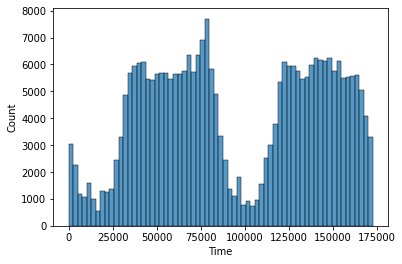

In [ ]:
sns.histplot(x=df['Time'])

In [ ]:
df['Time'].unique().shape

(124592,)

La variable `Time` contiene los segundos que pasaron entre la transaccion actual, y la primera transaccion del set de datos.

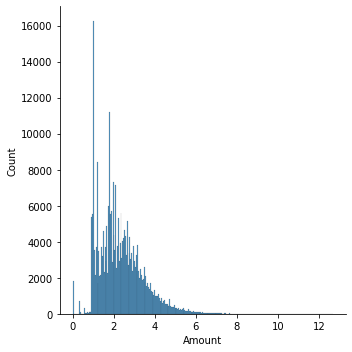

In [ ]:
sns.displot(x=(np.power(df['Amount'], .25)))

## Preparacion de Datos

In [ ]:
print('Null Values =',df.isnull().values.any())

Null Values = False


Por suerte no hay valores nulos en los datos!

# Split de datos

In [ ]:
Y = df["Class"]
X = df.loc[:, df.columns != 'Class']
test_size = 0.2
seed = 7

# Split train y test
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=test_size, random_state=seed)

# Split para validacion
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=test_size, random_state=seed)

print(f'Numero de fraudes en test: {Y_test.value_counts()}')
print(f'Numero de fraudes en train: {Y_train.value_counts()}')
print(f'Numero de fraudes en validacion: {Y_val.value_counts()}')

Numero de fraudes en test: 0    56862
1      100
Name: Class, dtype: int64
Numero de fraudes en train: 0    181967
1       309
Name: Class, dtype: int64
Numero de fraudes en validacion: 0    45486
1       83
Name: Class, dtype: int64


Parece que los datos de fraude $y=1$ estan balanceados entre train y test.   
Sin embargo el total de datos esta desbalanceado. Por ahora, ignoraremos esto, y probaremos varios modelos. Despues ataqueremos este problema directamente, y compararemos resultados.

# Seleccion de Variables

Notebook de seleccion de variables: https://github.com/IEXE-Tec/aprendizaje-maquina-2/blob/master/01_seleccion_de_variables.ipynb


Existen muchas tecnicas de estadistica clasica para Feature Selection ya sea tablas ANOVA, ANCOVA o diferentes tipos de correlacion para diferentes tipos de datos.

Post de [Feature Selection](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/)

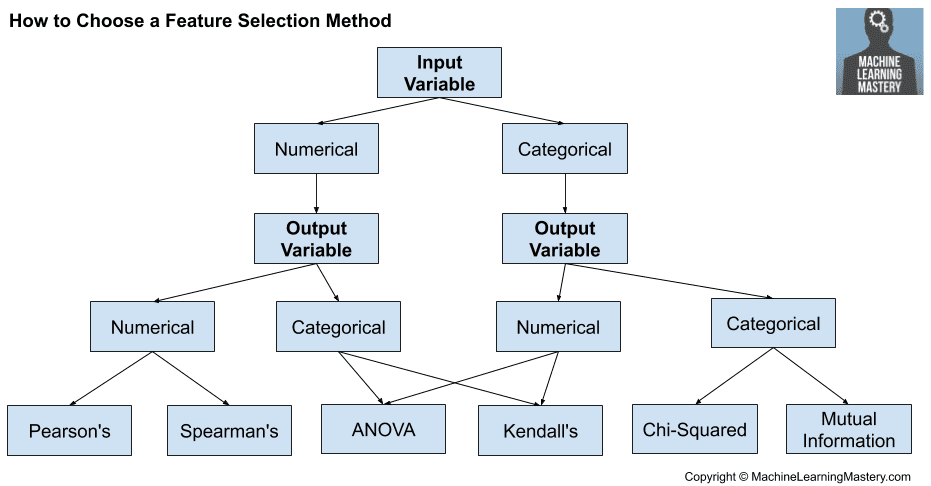

En nuestro caso nos saltaremos el **Feature Selection** para concentrarnos en los algoritmos y regularizacion.

El siguiente snippet contiene codigo de Kaggle para feature selection, utilizando Chi2. Aunque, esto no es del todo correcto, pues nuestras variables no son categoricas. Sin embargo, nos da una idea de la flexibilidad del ML.

In [ ]:
# ## No ejecutar
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2

# bestfeatures = SelectKBest( k=10)
# bestfeatures
# Y_train = df["Class"]
# X_train = df.loc[:, df.columns != 'Class']
# fit = bestfeatures.fit(X_train,Y_train)
# dfscores = pd.DataFrame(fit.scores_)
# dfcolumns = pd.DataFrame(X_train.columns)
# #concat two dataframes for better visualization
# featureScores = pd.concat([dfcolumns,dfscores],axis=1)
# featureScores.columns = ['Specs','Score']  #naming the dataframe columns
# print(featureScores.nlargest(10,'Score'))  #print 10 best features

### Tarea: Analisis de Time

**Tarea**
Propon una metrica para evaluar la importancia de la variable `Time`! Parece tomar muchos valores, y no necesariamente aportar mucho al modelaje.

#Feature engineering

Escalemos las variables numericas. Las otras variables no necesitan escalamiento, pues dado que fueron sometidas a PCA fueron escaladas previamente.

**Nota**: En estricto sentido el escalamiento o normalizacion deberia hacerse en sobre el train set, y despues aplicarse al test set. Sin embargo, es muy comun aplicar el escalamiento a todo el data set, pensando que no producira **data leakage**.

+ Para la variable **time** utilizaremos [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html). Ahora la variable se encuentrara entre 0 y 1. Dado que **no parece tener outliers**, y distribuirse mas o menos uniforme.
+ Para **Amount** utilizaremos [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html). La variable es escalda con los rangos intercuantiles. Lo elegimos por el tipo de distribucion que que **tiene outliers**.

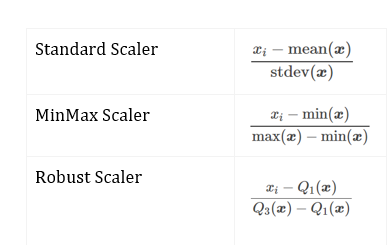

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# ##Time
time_scaler = MinMaxScaler().fit(X_train['Time'].values.reshape(-1,1))
# Entrenamos con train
X_train['time_scaled'] = time_scaler.transform(X_train['Time'].values.reshape(-1,1))
# Escalamos el test
X_test['time_scaled'] = time_scaler.transform(X_test['Time'].values.reshape(-1,1))
# Val
X_val['time_scaled'] = time_scaler.transform(X_val['Time'].values.reshape(-1,1))

# ##Amount
amount_scaler = RobustScaler().fit(X_train['Amount'].values.reshape(-1,1))
# Entrenamos con train
X_train['amount_scaled'] = amount_scaler.transform(X_train['Amount'].values.reshape(-1,1))
# Escalamos el test
X_test['amount_scaled'] = amount_scaler.transform(X_test['Amount'].values.reshape(-1,1))
# Val
X_val['amount_scaled'] = amount_scaler.transform(X_val['Amount'].values.reshape(-1,1))


In [ ]:
X_train[['time_scaled', 'amount_scaled']].describe()

,time_scaled,amount_scaled
count,182276.000000,182276.000000
mean,0.548166,0.922329
std,0.274679,3.329793
min,0.000000,-0.308166
25%,0.313182,-0.229724
50%,0.489149,0.000000
75%,0.806228,0.770276
max,1.000000,180.542513


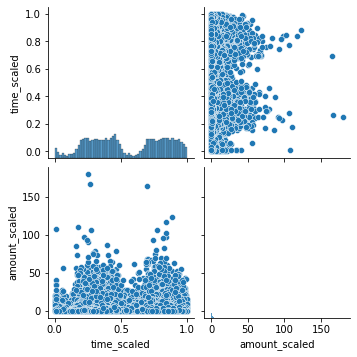

In [ ]:
sns.pairplot(data=X_train[['time_scaled', 'amount_scaled']])

In [ ]:
X_val[['time_scaled', 'amount_scaled']].describe()

,time_scaled,amount_scaled
count,45569.000000,45569.000000
mean,0.549103,0.940067
std,0.275370,3.488150
min,-0.000006,-0.308166
25%,0.312557,-0.228463
50%,0.492300,0.000981
75%,0.806228,0.791287
max,0.999959,142.561143


In [ ]:
X_train.drop(['Time', 'Amount'], axis=1, inplace=True)
X_test.drop(['Time', 'Amount'], axis=1, inplace=True)
X_val.drop(['Time', 'Amount'], axis=1, inplace=True)

# Modelaje

## Evaluacion de Modelos

Usaremos Cross Validation para elegir modelos. Una vez elegidos los modelos, utilizaremos CV de nuevo para tuneo de hiperparametros del modelo que elegimos.

Elijamos los Folds y los Modelos a utilizar

In [ ]:
# Opciones de Evaluacion de Modelos
num_folds = 5
seed = 7
# scoring ='f1'
scoring = 'accuracy'

# Modelos
models = []
models.append(('LR', LogisticRegression()))
#models.append(('RF', RandomForestClassifier()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))

CV sobre diferentes modelos

In [ ]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring,
                                 n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.999012 (0.000158)
LDA: 0.999386 (0.000143)
KNN: 0.998343 (0.000191)
CART: 0.999183 (0.000153)


## Evaluacion de LDA

[LDA doc](https://scikit-learn.org/0.16/modules/generated/sklearn.lda.LDA.html)

In [ ]:
# Llamar al Modelo
model = LinearDiscriminantAnalysis()
model.fit(X_train, Y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [ ]:
rescaledValidationX = X_train
predictions = model.predict(rescaledValidationX)
print(accuracy_score(Y_train, predictions))
print(confusion_matrix(Y_train, predictions))
print(classification_report(Y_train, predictions))

0.9993855471921701
[[181928     39]
 [    73    236]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    181967
           1       0.86      0.76      0.81       309

    accuracy                           1.00    182276
   macro avg       0.93      0.88      0.90    182276
weighted avg       1.00      1.00      1.00    182276



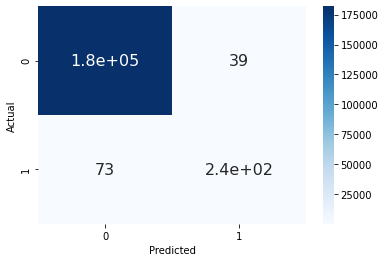

In [ ]:
df_cm = pd.DataFrame(confusion_matrix(Y_train, predictions),
                     columns=np.unique(Y_train), index = np.unique(Y_train))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

### LDA Validacion

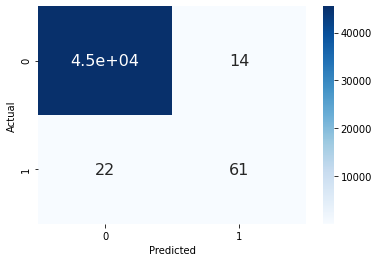

In [ ]:
predictions = model.predict(X_val)
df_cm = pd.DataFrame(confusion_matrix(Y_val, predictions),
                     columns=np.unique(Y_val), index = np.unique(Y_val))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

## Logistic Regression

**Tarea**: Agregar `l1_ratio` al gridsearch.

In [ ]:
# Numero de Arboles en el Bosque
penalty = ['l1', 'l2', 'elasticnet', 'none']
# Inverso de la Regularizacion
C = np.logspace(-4, 4, 20)
# Crea diccionario de busqueda
random_grid = {'penalty': penalty,
               'C': C}
pprint(random_grid)

{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
 'penalty': ['l1', 'l2', 'elasticnet', 'none']}


In [ ]:
# Construyamos el algoritmo
lr = LogisticRegression()
# Tuneo de Hyperparametros con CV
lr_random = GridSearchCV(estimator = lr, param_grid = random_grid,
                                scoring = 'accuracy',
                               cv = 5, verbose=2, n_jobs = -1)
# Entrenar
lr_random.fit(X_train, Y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  5.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.636...
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
      

In [ ]:
print(f'Mejores parametros: {lr_random.best_params_}')
print(f'Mejor Desempeño: {lr_random.best_score_}')

Mejores parametros: {'C': 0.0001, 'penalty': 'none'}
Mejor Desempeño: 0.9992099889761011


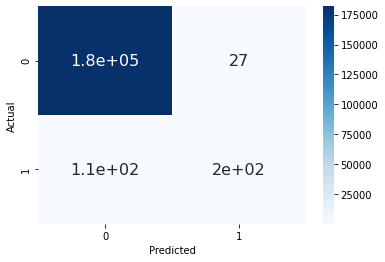

In [ ]:
lr_opt = LogisticRegression(**lr_random.best_params_)
lr_opt.fit(X_train, Y_train)

# Estimar Test
predictions = lr_opt.predict(X_train)
df_cm = pd.DataFrame(confusion_matrix(Y_train, predictions),
                     columns=np.unique(Y_train), index = np.unique(Y_train))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

### Logistic Regression Validacion

0.9990344313019817
[[45478     8]
 [   36    47]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45486
           1       0.85      0.57      0.68        83

    accuracy                           1.00     45569
   macro avg       0.93      0.78      0.84     45569
weighted avg       1.00      1.00      1.00     45569



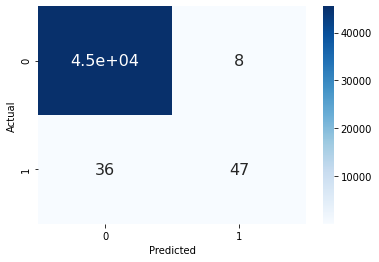

In [ ]:
lr_opt = LogisticRegression(**lr_random.best_params_)
lr_opt.fit(X_train, Y_train)

# Estimar Test
predictions = lr_opt.predict(X_val)
print(accuracy_score(Y_val, predictions))
print(confusion_matrix(Y_val, predictions))
print(classification_report(Y_val, predictions))

df_cm = pd.DataFrame(confusion_matrix(Y_val, predictions),
                     columns=np.unique(Y_val), index = np.unique(Y_val))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

# Modelaje con Undersampling

## Balanceo con Undersampling

Ahora entrenaremos modelos usando el metodo de **Random Under Sampling**. Consiste en remover datos aleatoriamente de la clase que tiene mas valores. De esta manera, nuestros modelos no van a sobreajustar a la clase dominante. Pasos:
1. Determinar que tan imbalaceada estan nuestras clases (usar value counts)
2. Despues balancemos las clases sampleando de manera aleatoria la que tiene mas numeros. Normalmente se busca tener algo cercano al 50/50.
3. Entrenar y Evaluar con las clases balanceadas.  
El principal riesgo de esta tecnica es que podemos perder muchos datos, lo cual puede afectar el desempeño de nuestros modelos. Por ejemplo, pasamos de 280,315 datos de no fraude a 492.

Rebalanceo en el train

Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


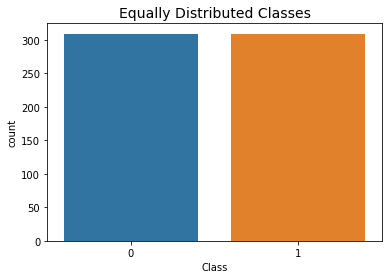

In [ ]:
df_train = pd.concat([X_train, Y_train], axis=1)
fraud_df = df_train.loc[df_train['Class'] == 1]
non_fraud_df = df_train.loc[df_train['Class'] == 0][:fraud_df.shape[0]]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle de datos de nuevo
df_new = normal_distributed_df.sample(frac=1, random_state=42)
# split out validation dataset for the end
Y_train_new= df_new["Class"]
X_train_new = df_new.loc[:, df.columns != 'Class']


print('Distribucion de las Clases en el Data Set')
print(df_new['Class'].value_counts()/len(df_new))
sns.countplot('Class', data=df_new)
pyplot.title('Clases balanceadas', fontsize=14)
pyplot.show()

In [ ]:
class_names = {0:'Not Fraud', 1:'Fraud'}
print(df_new.Class.value_counts().rename(index = class_names))

Fraud        309
Not Fraud    309
Name: Class, dtype: int64


## Evaluacion de modelos Undersampling

In [ ]:
# Opciones de Evaluacion de Modelos
num_folds = 10
seed = 7
# scoring ='f1'
scoring = 'accuracy'

# ### Modelos
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
#Neural Network
models.append(('NN', MLPClassifier()))
# #Ensable Models
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

**Red Neuronal Profunda con Keras**

In [ ]:
# Modelo de red Neuronal
# Si deseas entrenarlo pon el flag=1
EnableDLModelsFlag = 1
if EnableDLModelsFlag == 1 :
    # Creacion del modelo con Keras
    def create_model(neurons=12, activation='relu', learn_rate = 0.01, momentum=0):
        # create model
        model = Sequential()
        model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation=activation))
        model.add(Dense(32, activation=activation))
        model.add(Dense(1, activation='sigmoid'))
        # Compilar Modelo
        optimizer = SGD(lr=learn_rate, momentum=momentum)
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model
    models.append(('DNN', KerasClassifier(build_fn=create_model, epochs=50, batch_size=10, verbose=0)))

In [ ]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train_new, Y_train_new, cv=kfold,
                                 scoring=scoring, n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.938525 (0.022554)
LDA: 0.914252 (0.026145)
KNN: 0.945003 (0.021834)
CART: 0.876970 (0.030210)
NB: 0.920730 (0.037111)
SVM: 0.928794 (0.020690)
NN: 0.941724 (0.016537)
AB: 0.919117 (0.031391)
GBM: 0.927208 (0.019383)
RF: 0.935299 (0.021583)
ET: 0.932047 (0.021370)
DNN: 0.925568 (0.020653)


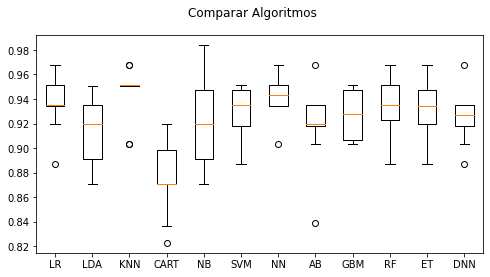

In [ ]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Comparar Algoritmos')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(8,4)
pyplot.show()

## Logistic Regression

Documentacion [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

### Logistic Regression Training

**Tarea**
Gridsearch con `l1_ratio`.

In [ ]:
# Numero de Arboles en el Bosque
penalty = ['l1', 'l2', 'elasticnet', 'none']
# Inverso de la Regularizacion
C = np.logspace(-4, 4, 20)

# Crea diccionario de busqueda
random_grid = {'penalty': penalty,
               'C': C}
pprint(random_grid)

{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
 'penalty': ['l1', 'l2', 'elasticnet', 'none']}


In [ ]:
# Construyamos el algoritmo
lr = LogisticRegression()
# Tuneo de Hyperparametros con CV
lr_random = GridSearchCV(estimator = lr, param_grid = random_grid,
                                scoring = 'accuracy',
                               cv = 5, verbose=2, n_jobs = -1)
# Entrenar
lr_random.fit(X_train_new, Y_train_new)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    6.4s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.636...
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
      

In [ ]:
print(f'Mejores parametros: {lr_random.best_params_}')
print(f'Mejor Desempeño: {lr_random.best_score_}')

Mejores parametros: {'C': 0.23357214690901212, 'penalty': 'l2'}
Mejor Desempeño: 0.9529820261437908


0.9611650485436893
[[303   6]
 [ 18 291]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       309
           1       0.98      0.94      0.96       309

    accuracy                           0.96       618
   macro avg       0.96      0.96      0.96       618
weighted avg       0.96      0.96      0.96       618



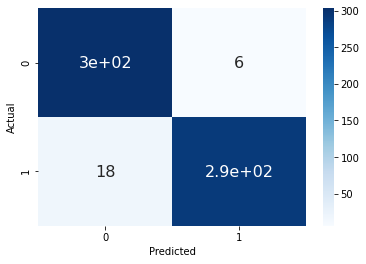

In [ ]:
lr_opt = LogisticRegression(**lr_random.best_params_)
lr_opt.fit(X_train_new, Y_train_new)

# Estimar Test
predictions = lr_opt.predict(X_train_new)
print(accuracy_score(Y_train_new, predictions))
print(confusion_matrix(Y_train_new, predictions))
print(classification_report(Y_train_new, predictions))

df_cm = pd.DataFrame(confusion_matrix(Y_train_new, predictions),
                     columns=np.unique(Y_train_new), index = np.unique(Y_train_new))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

### Logistic Regression Val

0.9603677938949725
[[43690  1796]
 [   10    73]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     45486
           1       0.04      0.88      0.07        83

    accuracy                           0.96     45569
   macro avg       0.52      0.92      0.53     45569
weighted avg       1.00      0.96      0.98     45569



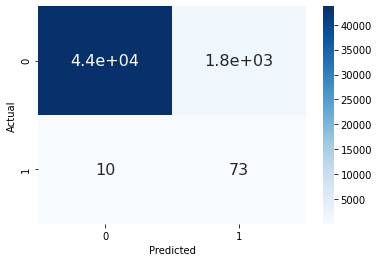

In [ ]:
lr_opt = LogisticRegression(**lr_random.best_params_)
lr_opt.fit(X_train_new, Y_train_new)

# Estimar Test
predictions = lr_opt.predict(X_val)
print(accuracy_score(Y_val, predictions))
print(confusion_matrix(Y_val, predictions))
print(classification_report(Y_val, predictions))

df_cm = pd.DataFrame(confusion_matrix(Y_val, predictions),
                     columns=np.unique(Y_val), index = np.unique(Y_val))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

### ROC

## Random Forest

### Tuneo de Random Forest

Documentacion a [RandomForestClassifer](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [ ]:
rf = RandomForestClassifier(random_state = 42)
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


Son muchos parametros, concentremonos en los mas importantes:

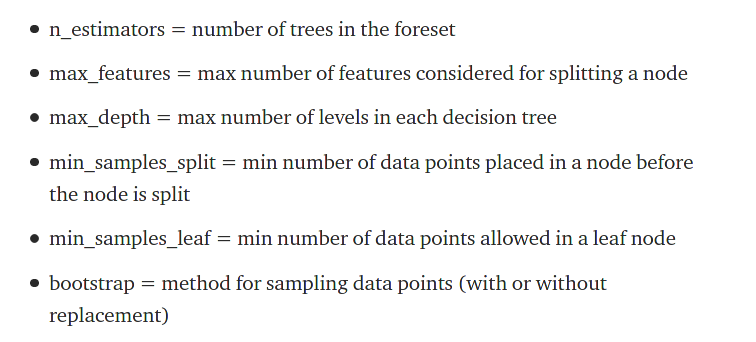

Parametros a buscar con Random Forest

In [ ]:
# Numero de Arboles en el Bosque
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]
# Numero de Variables por split, tecnica
max_features = ['auto']
# Profundidad del Arbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Numero minimo de observaciones para hacer el Split
min_samples_split = [2, 5, 10]
# Minimo numero de observaciones en las hojas
min_samples_leaf = [1, 2, 4]
# Metodo para elegir las observaciones en cada paso
bootstrap = [True]
# Crea el grid de busqueda
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 325, 550, 775, 1000]}


#### Accuracy

Tiempo 45 mins

In [ ]:
rf = RandomForestClassifier(random_state = 42)
# Tuneo de Hyperparametros con CV
rf_under = GridSearchCV(estimator = rf, param_grid = random_grid,
                                scoring = 'accuracy',
                               cv = 5, verbose=2, n_jobs = -1)
# Entrenar
rf_under.fit(X_train_new, Y_train_new)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 24.6min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 33.4min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 43.5min
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed: 45.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

Mejores Parametros

In [ ]:
print(f'Mejores parametros: {rf_under.best_params_}')
print(f'Mejor Desempeño: {rf_under.best_score_}')

Mejores parametros: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 325}
Mejor Desempeño: 0.940112772095463


#### F1 Score

In [ ]:
# Numero de Arboles en el Bosque
n_estimators = [int(x) for x in np.linspace(start = 300, stop = 500, num = 3)]
# Numero de Variables por split, tecnica
max_features = ['auto']
# Profundidad del Arbol
max_depth = [int(x) for x in np.linspace(8, 12, num = 3)]
max_depth.append(None)
# Numero minimo de observaciones para hacer el Split
min_samples_split = [ 8, 10, 12]
# Minimo numero de observaciones en las hojas
min_samples_leaf = [3, 4]
# Metodo para elegir las observaciones en cada paso
bootstrap = [True]
# Crea el grid de busqueda
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True],
 'max_depth': [8, 10, 12, None],
 'max_features': ['auto'],
 'min_samples_leaf': [3, 4],
 'min_samples_split': [8, 10, 12],
 'n_estimators': [300, 400, 500]}


In [ ]:
# Construyamos el algoritmo
rf = RandomForestClassifier(random_state = 42)
# Tuneo de Hyperparametros con CV
rf_under_f1 = GridSearchCV(estimator = rf, param_grid = random_grid,
                                scoring = 'f1',
                               cv = 5, verbose=2, n_jobs = -1)
# Entrenar
rf_under_f1.fit(X_train_new, Y_train_new)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  4.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [ ]:
print('Anterior')
print(f'Mejores parametros: {rf_under.best_params_}')
print(f'Mejor Desempeño: {rf_under.best_score_}')

print('F1 score')
print(f'Mejores parametros f1: {rf_under_f1.best_params_}')
print(f'Mejor Desempeño f1: {rf_under_f1.best_score_}')

Anterior
Mejores parametros: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 325}
Mejor Desempeño: 0.940112772095463
F1 score
Mejores parametros f1: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Mejor Desempeño f1: 0.9369254492519727


En ambos casos parece que mas estimadores `n_estimators` mejora la prediccion. Tuneomos un poco mas este hyperparametro.

#### Random Search RF V2

In [ ]:
# Numero de Arboles en el Bosque
n_estimators = [int(x) for x in np.linspace(start = 280, stop = 330, num = 5)]
# Numero de Variables por split, tecnica
max_features = ['auto']
# Profundidad del Arbol
max_depth = [10]
max_depth.append(None)
# Numero minimo de observaciones para hacer el Split
min_samples_split = [9,10,11,12]
# Minimo numero de observaciones en las hojas
min_samples_leaf = [1]
# Metodo para elegir las observaciones en cada paso
bootstrap = [True]
# Crea el grid de busqueda
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True],
 'max_depth': [10, None],
 'max_features': ['auto'],
 'min_samples_leaf': [1],
 'min_samples_split': [9, 10, 11, 12],
 'n_estimators': [280, 292, 305, 317, 330]}


In [ ]:
# Construyamos el algoritmo
rf = RandomForestClassifier(random_state = 42)
# Tuneo de Hyperparametros con CV
rf_random2 = GridSearchCV(estimator = rf, param_grid = random_grid,
                                scoring = 'accuracy',
                               cv = 5, verbose=2, n_jobs = -1)
# Entrenar
rf_random2.fit(X_train_new, Y_train_new)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [ ]:
print('Ultimo RF')
print(f'Mejores parametros: {rf_random2.best_params_}')
print(f'Mejor Desempeño 2: {rf_random2.best_score_}')
print('\n RF optimo anteriro')
print(f'Mejor Desempeño 1: {rf_under.best_score_}')
print(f'Mejores parametros: {rf_under.best_params_}')


Ultimo RF
Mejores parametros: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 305}
Mejor Desempeño 2: 0.940112772095463

 RF optimo anteriro
Mejor Desempeño 1: 0.940112772095463
Mejores parametros: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 325}


In [ ]:
rf_cv = pd.DataFrame(rf_random2.cv_results_)
rf_cv[['mean_test_score', 'std_test_score', 'params']].sort_values('mean_test_score'
, ascending=False).head(20)

,mean_test_score,std_test_score,params
2,0.940113,0.012226,"{'bootstrap': True, 'max_depth': 10, 'max_feat..."
0,0.938487,0.011133,"{'bootstrap': True, 'max_depth': 10, 'max_feat..."
3,0.938487,0.011133,"{'bootstrap': True, 'max_depth': 10, 'max_feat..."
4,0.938487,0.011133,"{'bootstrap': True, 'max_depth': 10, 'max_feat..."
1,0.938487,0.011133,"{'bootstrap': True, 'max_depth': 10, 'max_feat..."
27,0.936874,0.010863,"{'bootstrap': True, 'max_depth': None, 'max_fe..."
22,0.936874,0.010863,"{'bootstrap': True, 'max_depth': None, 'max_fe..."
23,0.936874,0.010863,"{'bootstrap': True, 'max_depth': None, 'max_fe..."
24,0.936874,0.010863,"{'bootstrap': True, 'max_depth': None, 'max_fe..."
25,0.936874,0.010863,"{'bootstrap': True, 'max_depth': None, 'max_fe..."


In [ ]:
rf_cv = pd.DataFrame(rf_under.cv_results_)
rf_cv[['mean_test_score', 'std_test_score', 'params']].sort_values('mean_test_score'
, ascending=False).head(20)

,mean_test_score,std_test_score,params
401,0.940113,0.012226,"{'bootstrap': True, 'max_depth': 90, 'max_feat..."
426,0.940113,0.016783,"{'bootstrap': True, 'max_depth': 100, 'max_fea..."
41,0.940113,0.012226,"{'bootstrap': True, 'max_depth': 10, 'max_feat..."
491,0.940113,0.012226,"{'bootstrap': True, 'max_depth': 110, 'max_fea..."
381,0.940113,0.016783,"{'bootstrap': True, 'max_depth': 90, 'max_feat..."
356,0.940113,0.012226,"{'bootstrap': True, 'max_depth': 80, 'max_feat..."
176,0.940113,0.012226,"{'bootstrap': True, 'max_depth': 40, 'max_feat..."
336,0.940113,0.016783,"{'bootstrap': True, 'max_depth': 80, 'max_feat..."
131,0.940113,0.012226,"{'bootstrap': True, 'max_depth': 30, 'max_feat..."
201,0.940113,0.016783,"{'bootstrap': True, 'max_depth': 50, 'max_feat..."


Parece que el desempeño es marginalmente mejor con mas estimadores, sin embargo, usemos el modelo parsimonioso.

## Feature Importance

Ejecutar `feature_importance` con el mejor modelo de Random Forest (training)

In [ ]:
rf_fi= RandomForestClassifier(**rf_under.best_params_, random_state=9847156)

## Random Forest Validacion

0.9774188593122517
[[44467  1019]
 [   10    73]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     45486
           1       0.07      0.88      0.12        83

    accuracy                           0.98     45569
   macro avg       0.53      0.93      0.56     45569
weighted avg       1.00      0.98      0.99     45569



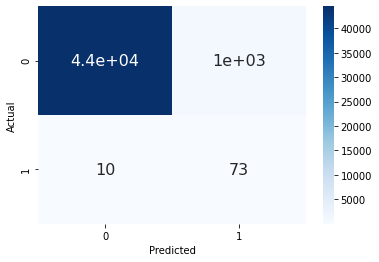

In [ ]:
rf_opt = RandomForestClassifier(**rf_under.best_params_)
rf_opt.fit(X_train_new, Y_train_new)

# Estimar Test
predictions = rf_opt.predict(X_val)
print(accuracy_score(Y_val, predictions))
print(confusion_matrix(Y_val, predictions))
print(classification_report(Y_val, predictions))

df_cm = pd.DataFrame(confusion_matrix(Y_val, predictions),
                     columns=np.unique(Y_val), index = np.unique(Y_val))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

0.9737101977221356
[[44299  1187]
 [   11    72]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     45486
           1       0.06      0.87      0.11        83

    accuracy                           0.97     45569
   macro avg       0.53      0.92      0.55     45569
weighted avg       1.00      0.97      0.99     45569



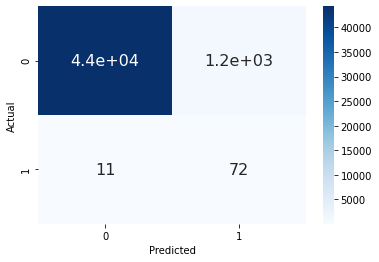

In [ ]:
rf_opt = RandomForestClassifier(**rf_random2.best_params_)
rf_opt.fit(X_train_new, Y_train_new)

# Estimar Test
predictions = rf_opt.predict(X_val)
print(accuracy_score(Y_val, predictions))
print(confusion_matrix(Y_val, predictions))
print(classification_report(Y_val, predictions))

df_cm = pd.DataFrame(confusion_matrix(Y_val, predictions),
                     columns=np.unique(Y_val), index = np.unique(Y_val))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

# Mejor modelo

+ Piensa cual seria el mejor modelo si el costo de los falsos positivos es casi el mismo que el de los falsos negativos?  
+ Que pasa esi el costo de los falsos positivos es mucho mayor?

In [ ]:
rf_opt = RandomForestClassifier(**rf_random2.best_params_, random_state=35)
rf_opt.fit(X_train_new, Y_train_new)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, n_estimators=305,
                       n_jobs=None, oob_score=False, random_state=35, verbose=0,
                       warm_start=False)

In [ ]:
# Estimar Test
predictions = rf_opt.predict(X_test)
print(accuracy_score(Y_test, predictions))
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

df_cm = pd.DataFrame(confusion_matrix(Y_test, predictions),
                     columns=np.unique(Y_test), index = np.unique(Y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
df_cm

0.973807099469822
[[55379  1483]
 [    9    91]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56862
           1       0.06      0.91      0.11       100

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.97      0.99     56962



Predicted,0,1
Actual,,
0,55379,1483
1,9,91
